In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 11.5 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remo

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2, SPReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# from src.running import train_step1, eval_step1

<ipython-input-4-751845880af3>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [33]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 64,
    'neighs': 10,
    "model_params":{
        "linear_filters":[1024,1024,1024,400],
        "input_feat":36,
        "dropout":0.1,
    },
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
sdataReader = SPReader(IMU_data_path)

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1092: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [10]:
def read_I3D_pkl(loc, action_list, feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  i3ds = {}
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    i3ds[action_list.index(k)] = np.asarray(all_arr)
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "prototype":prototype, 'features': i3ds}

In [11]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path, actionList, feat_size="400")
video_classes, video_feat, feat_dict = video_data['activity'], video_data['prototype'], video_data['features']

In [12]:
# re-arrange semantic space
activity_dict = dict(zip(video_classes, video_feat))
semantic_space = np.array([activity_dict[c] for c in actionList])

In [13]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [14]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [15]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

---

In [16]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [18]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [19]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [20]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [21]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [22]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [23]:
def gen_semantic_space(ft_dict, seen_classes):
    action_ft = np.concatenate(list(ft_dict.values()), axis=0)

    class_dict = {c: i for i,c in enumerate(seen_classes)}
    n_cls = len(seen_classes)
    action_label = []
    for k in list(ft_dict.keys()):
        d = k # class_dict[k]
        for _ in range(ft_dict[k].shape[0]):
            action_label.append(d)

    action_label = np.array(action_label)
    return action_ft, action_label

In [45]:
def unseen_eval_step(smodel, tmodel, dataloaderS, dalaloaderT, sem_actions, sem_labels, loss_module, device, class_names, class_ids, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7, neighs=5):
    smodel = smodel.eval()
    tmodel = tmodel.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targetS': [], 'targetT': [], 'predictionS': [], 'predictionT': [], 'metrics': [], 'IDs': [], 'featS': [], 'featT': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    

    ld = dict(zip(class_ids, range(len(class_ids))))
    all_actions = sem_actions
    all_labels = np.array([ld[e] for e in sem_labels])
    # build knn model on know unseen samples 
    clf = KNeighborsClassifier(n_neighbors=neighs, algorithm='auto', metric='cosine', metric_params=None, n_jobs=None, weights='distance')
    clf.fit(sem_actions, all_labels)

    # dl1_iter = iter(dalaloaderT)

    with tqdm(dataloaderS, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            Xs, targetS, target_featS = batch
            Xt, targetT, target_featT = next(iter(dalaloaderT))
            Xs = Xs.float().to(device)
            Xt = Xt.float().to(device)
            target_feats = target_featS.float().to(device)
            targetS = targetS.long().to(device)
            targetT = targetT.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_outputs = smodel(Xs)
                feat_outputt = tmodel(Xt)

            # convert feature vector into action class using cosine
            featt_numpy = feat_outputt.cpu().detach().numpy()
            feats_numpy = feat_outputs.cpu().detach().numpy()
            predt_action = clf.predict(featt_numpy)
            preds_action = clf.predict(feats_numpy)
  
            with torch.no_grad():
                metrics['samples'] += len(targetS)

            per_batch['targetS'].append(targetS.cpu().numpy())
            per_batch['targetT'].append(targetT.cpu().numpy())
            per_batch['predictionS'].append(preds_action)
            per_batch['predictionT'].append(predt_action)
            per_batch['featT'].append(featt_numpy)
            per_batch['featS'].append(feats_numpy)

    all_predS = np.concatenate(per_batch["predictionS"])
    all_predT = np.concatenate(per_batch["predictionT"])
    all_targets = np.concatenate(per_batch["targetS"])
    all_targetT = np.concatenate(per_batch["targetT"])
    all_featS = np.concatenate(per_batch["featS"])
    all_featT = np.concatenate(per_batch["featT"])
    metrics_dict = action_evaluator(y_pred=all_predS, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    label2Id = dict(zip(range(len(class_ids)), class_names))
    return metrics_dict, sem_actions, all_labels, all_featT, all_featS, all_predS, all_predT, label2Id

In [25]:
# def over_plot_preds(gt_actions, gt_labels, pred_actions, pred_labels, Id2Label):
#     gt_n = gt_actions.shape[0]
#     pred_n = pred_actions.shape[0]

#     all_actions = np.concatenate([gt_actions, pred_actions])
#     all_labels = np.concatenate([gt_labels, pred_labels])
#     all_types = ['GT',]*gt_n + ['pred',]*pred_n

#     tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
#     gt_data = tnse.fit_transform(all_actions)

#     gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
#     gt_df['label'] = all_labels 
#     gt_df['action'] = gt_df['label'].map(Id2Label)
#     gt_df['type'] = all_types

#     plt.figure(figsize=(6, 6))
#     sns.scatterplot(data=gt_df, x='x', y='y', hue='action', style='type')
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     plt.show()

In [26]:
def over_plot_preds(gt_actions, gt_labels, pred_actionT, pred_actionS, pred_labelS, pred_labelT, Id2Label):
    gt_n = gt_actions.shape[0]
    predS_n = pred_actionS.shape[0]
    predT_n = pred_actionT.shape[0]

    all_actions = np.concatenate([gt_actions, pred_actionS, pred_actionT])
    all_labels = np.concatenate([gt_labels, pred_labelS, pred_labelT])
    all_types = ['GT',]*gt_n + ['predS',]*predS_n + ['predT',]*predT_n

    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    gt_data = tnse.fit_transform(all_actions)

    gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
    gt_df['label'] = all_labels 
    gt_df['action'] = gt_df['label'].map(Id2Label)
    gt_df['type'] = all_types

    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=gt_df, x='x', y='y', hue='action', style='type')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [27]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [28]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [29]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-29-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-186


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.259



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.364



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.502



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.742



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.822



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.846



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.873



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.924



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.934



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.977



train:   0%|          | 0/142 [00:00<?, ?batch/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.989



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

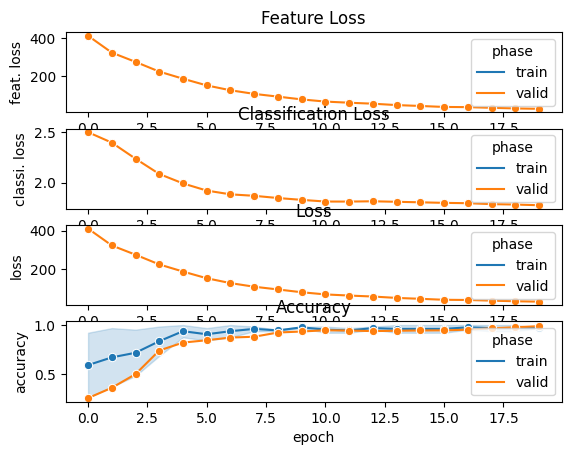

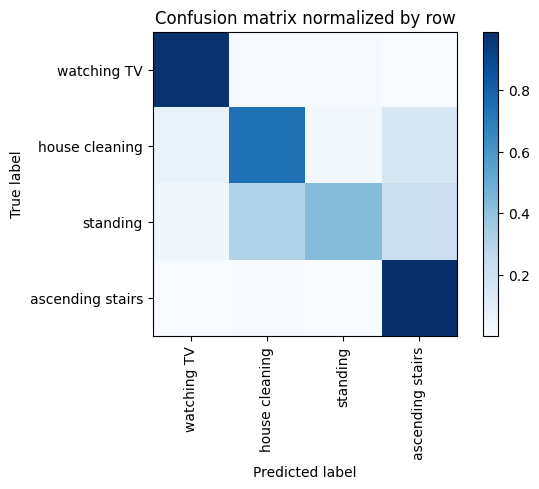

Overall accuracy: 0.722

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.923      0.431      0.587      0.332       1848|	 house cleaning: 0.312,	ascending stairs: 0.218,	
  house cleaning       0.696      0.744      0.719      0.328       1826|	 ascending stairs: 0.156,	watching TV: 0.070,	
ascending stairs       0.606      0.990      0.752      0.193       1072|	 house cleaning: 0.007,	standing: 0.002,	
     watching TV       0.799      0.977      0.879      0.148        822|	 standing: 0.011,	house cleaning: 0.010,	

----------------------------------------------------------------------------------------------------
     avg / total       0.769      0.722      0.705        1.0       5568|	      



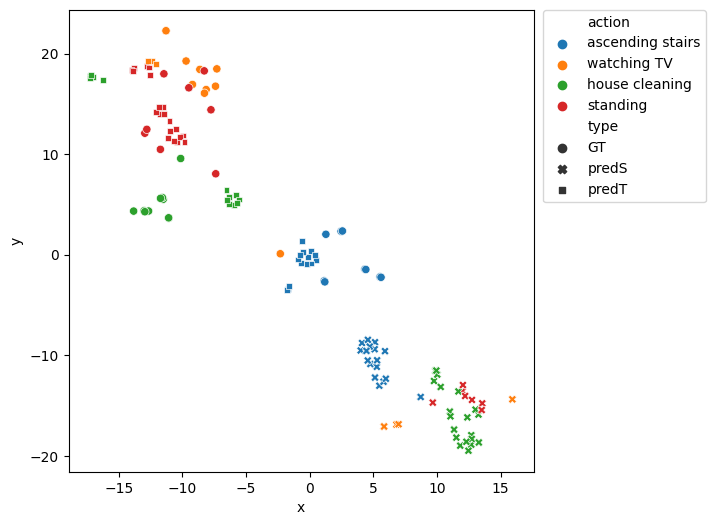

{'accuracy': 0.7216235632183908, 'precision': 0.7561944675292485, 'recall': 0.7852656156316038, 'f1': 0.7343821858227366, 'samples': 5568, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
============== Overall Unseen Classes Performance ==============
accuracy     0.721624
precision    0.756194
recall       0.785266
f1           0.734382
dtype: float64
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-186/metadata


In [48]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    data_dictS = sdataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build IMU datasets
    train_dtS = PAMAP2Dataset(data=data_dictS['train']['X'], actions=data_dictS['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dlS = DataLoader(train_dtS, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dtS = PAMAP2Dataset(data=data_dictS['eval-seen']['X'], actions=data_dictS['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dlS = DataLoader(eval_dtS, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dtS = PAMAP2Dataset(data=data_dictS['test']['X'], actions=data_dictS['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dlS = DataLoader(test_dtS, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    

    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    Tmodel = IMUEncoder(**imu_config)
    Tmodel.to(device)

    # build model
    Smodel = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    Smodel.to(device)

    seen_feat_dict = {a: f for a,f in feat_dict.items() if a in seen_classes}
    unseen_feat_dict = {a: f for a,f in feat_dict.items() if a in unseen_classes}
    seen_action_ft, seen_action_label = gen_semantic_space(seen_feat_dict, seen_classes)
    unseen_action_ft, unseen_action_label = gen_semantic_space(unseen_feat_dict, unseen_classes)

    # define run parameters 
    optimizerT = Adam(Tmodel.parameters(), lr=config['lr'], weight_decay=1e-6)
    optimizerS = Adam(Smodel.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(Tmodel, train_dl, train_dt,optimizerT, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        train_metrics = train_step(Smodel, train_dlS, train_dtS, optimizerS, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(Tmodel, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(Tmodel.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    # model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics, a,b,c,d,e,f,g = unseen_eval_step(Smodel, Tmodel, test_dlS, test_dl, unseen_action_ft, unseen_action_label, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes, phase='unseen', loss_alpha=config['imu_alpha'], print_report=True, show_plot=True, neighs=config['neighs'])
    # over_plot_preds(a,b,c,d,e,f,g)
    over_plot_preds(a,b,c[:50, :],d[:50, :],e[:50], f[:50],g)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)
    break

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()


In [92]:
def over_plot_predsV0(gt_actions, gt_labels, pred_actionT, pred_actionS, pred_labelS, pred_labelT, Id2Label):
    gt_n = gt_actions.shape[0]
    predS_n = pred_actionS.shape[0]
    predT_n = pred_actionT.shape[0]

    all_actions = np.concatenate([gt_actions, pred_actionS, pred_actionT])
    all_labels = np.concatenate([gt_labels, pred_labelS, pred_labelT])
    all_types = ['ground-truth',]*gt_n + ['VideoSOTA',]*predS_n + ['TEZARNet',]*predT_n

    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    gt_data = tnse.fit_transform(all_actions)

    gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
    gt_df['label'] = all_labels 
    gt_df['action'] = gt_df['label'].map(Id2Label)
    gt_df['type'] = all_types

    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=gt_df, x='x', y='y', hue='action', style='type')
    plt.legend(bbox_to_anchor=(0.79, 1), loc='upper left', borderaxespad=0)
    plt.show()

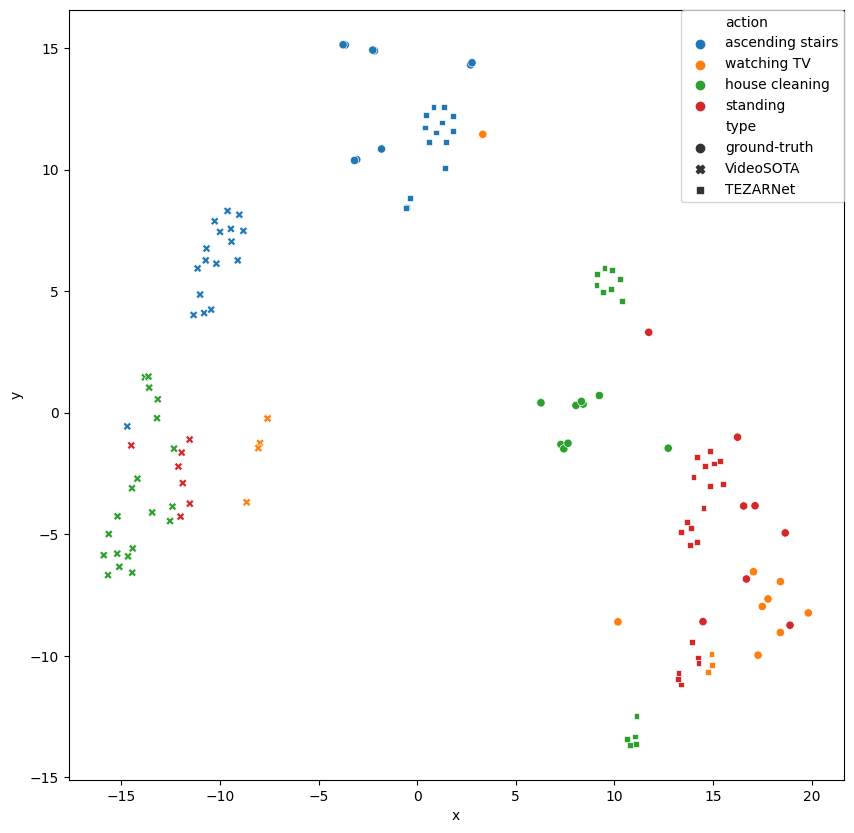

In [96]:
over_plot_predsV0(a,b,c[:50, :],d[:50, :],e[:50], f[:50],g)